In [1]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape,RepeatVector
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout,MaxPooling1D,AveragePooling1D,Flatten,Bidirectional


import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.data_split import split_sequence_parallel

# 不加这几句，则CONV 报错
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
data = pd.read_csv("D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\\InfoGainTiantandata.csv", header=0,infer_datetime_format=True, engine='python')
data['Unnamed: 0']=pd.to_datetime(data['Unnamed: 0'])
data.set_index("Unnamed: 0",inplace=True)

In [3]:
'''
归一化
'''
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler5 = MinMaxScaler(feature_range=(0, 1))
scaler6 = MinMaxScaler(feature_range=(0, 1))
scaler7 = MinMaxScaler(feature_range=(0, 1))
scaler8 = MinMaxScaler(feature_range=(0, 1))
scaler9 = MinMaxScaler(feature_range=(0, 1))
scaler10 = MinMaxScaler(feature_range=(0, 1))
scaler11 = MinMaxScaler(feature_range=(0, 1))
scaler12 = MinMaxScaler(feature_range=(0, 1))
scaler13 = MinMaxScaler(feature_range=(0, 1))
scaler14 = MinMaxScaler(feature_range=(0, 1))
scaler15 = MinMaxScaler(feature_range=(0, 1))
data_minmax = data.copy()
data_minmax['PM2.5']=scaler1.fit_transform(data_minmax['PM2.5'].values.reshape(-1,1))
data_minmax['PM10']=scaler2.fit_transform(data_minmax['PM10'].values.reshape(-1,1))
data_minmax['SO2']=scaler3.fit_transform(data_minmax['SO2'].values.reshape(-1,1))
data_minmax['NO2']=scaler4.fit_transform(data_minmax['NO2'].values.reshape(-1,1))
data_minmax['CO']=scaler5.fit_transform(data_minmax['CO'].values.reshape(-1,1))
data_minmax['O3']=scaler6.fit_transform(data_minmax['O3'].values.reshape(-1,1))
data_minmax['TEMP']=scaler7.fit_transform(data_minmax['TEMP'].values.reshape(-1,1))
data_minmax['PRES']=scaler8.fit_transform(data_minmax['PRES'].values.reshape(-1,1))
data_minmax['DEWP']=scaler9.fit_transform(data_minmax['DEWP'].values.reshape(-1,1))
data_minmax['wd_E']=scaler10.fit_transform(data_minmax['wd_E'].values.reshape(-1,1))
data_minmax['wd_ENE']=scaler11.fit_transform(data_minmax['wd_ENE'].values.reshape(-1,1))
data_minmax['wd_ESE']=scaler12.fit_transform(data_minmax['wd_ESE'].values.reshape(-1,1))
data_minmax['wd_NE']=scaler13.fit_transform(data_minmax['wd_NE'].values.reshape(-1,1))
data_minmax['wd_NW']=scaler14.fit_transform(data_minmax['wd_NW'].values.reshape(-1,1))
data_minmax['wd_SW']=scaler15.fit_transform(data_minmax['wd_SW'].values.reshape(-1,1))

In [4]:
'''
取一年的时间，10个月做训练和验证，2个月做测试
'''
cast1 = -10200
cast2 = -2880
cast3 = -1416                                                                      
data_train = data_minmax[cast1:cast2]
data_test = data_minmax[cast2:cast3] 
data_train.shape,data_test.shape

((7320, 15), (1464, 15))

In [5]:
data_test = np.array(data_test)
data_train = np.array(data_train)
data_train.shape,data_test.shape

((7320, 15), (1464, 15))

In [6]:
sw_width = 21
pred_length = 12
verbose_set = 2
X, y, features = split_sequence_parallel(data_train,sw_width,pred_length)
test_x,test_y,test_features = split_sequence_parallel(data_test,sw_width,pred_length)

In [7]:
def Daqff():
    ip = Input(shape=(sw_width,features))
    
    y = Conv1D(64, 5, padding='same', kernel_initializer='he_uniform')(ip)    
    y = Activation('relu')(y)
#     y = MaxPooling1D(pool_size=2)(y)
#     y = Dropout(0.3)(y)

    y = Conv1D(64, 3,padding='same',kernel_initializer='he_uniform')(y)
#     y = Dropout(0.3)(y)
    y = Activation('relu')(y)
#     y = Dropout(0.3)(y)

    y = Conv1D(64, 3,padding='same',kernel_initializer='he_uniform')(y)
    y = Activation('relu')(y)
#     y = Dropout(0.3)(y)
     
    y = Bidirectional(LSTM(64,activation="relu"))(y)
    y = Dropout(0.3)(y)
    y = Dense(pred_length)(y)
    model = Model(ip, y)
    model.summary()


    return model

In [8]:
Daqff1 = Daqff()
Daqff1

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 15)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 64)            4864      
_________________________________________________________________
activation_1 (Activation)    (None, 21, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 64)            12352     
_________________________________________________________________
activation_2 (Activation)    (None, 21, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 21, 64)            12352     
_________________________________________________________________
activation_3 (Activation)    (None, 21, 64)            0   

In [18]:
import time
from keras import backend as K
from keras.callbacks import ModelCheckpoint
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

filepath = "D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\\12hourweights\DAQFF_model_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
callbacks_list = [checkpoint]
starttime=time.time()
Daqff1.compile(loss=root_mean_squared_error, optimizer='adam')
history1 = Daqff1.fit(X,y,validation_split=0.33,epochs=60, batch_size=32,callbacks=callbacks_list, verbose=2)
endtime=time.time()
dtime=endtime-starttime
print("程序运行时间为：%.8s s" % dtime)  #时间显示到微秒

Train on 4882 samples, validate on 2406 samples
Epoch 1/60
 - 10s - loss: 0.0538 - val_loss: 0.0389

Epoch 00001: val_loss improved from inf to 0.03889, saving model to D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\12hourweights\DAQFF_model_weights_best.hdf5
Epoch 2/60
 - 8s - loss: 0.0507 - val_loss: 0.0418

Epoch 00002: val_loss did not improve from 0.03889
Epoch 3/60
 - 6s - loss: 0.0487 - val_loss: 0.0424

Epoch 00003: val_loss did not improve from 0.03889
Epoch 4/60
 - 6s - loss: 0.0466 - val_loss: 0.0395

Epoch 00004: val_loss did not improve from 0.03889
Epoch 5/60
 - 6s - loss: 0.0450 - val_loss: 0.0394

Epoch 00005: val_loss did not improve from 0.03889
Epoch 6/60
 - 6s - loss: 0.0427 - val_loss: 0.0407

Epoch 00006: val_loss did not improve from 0.03889
Epoch 7/60
 - 6s - loss: 0.0416 - val_loss: 0.0410

Epoch 00007: val_loss did not improve from 0.03889
Epoch 8/60
 - 6s - loss: 0.0393 - val_loss: 0.0406

Epoch 00008: val_loss did not improve from 0.03889
Epoch 9/60
 - 6s - loss: 0.0393 -

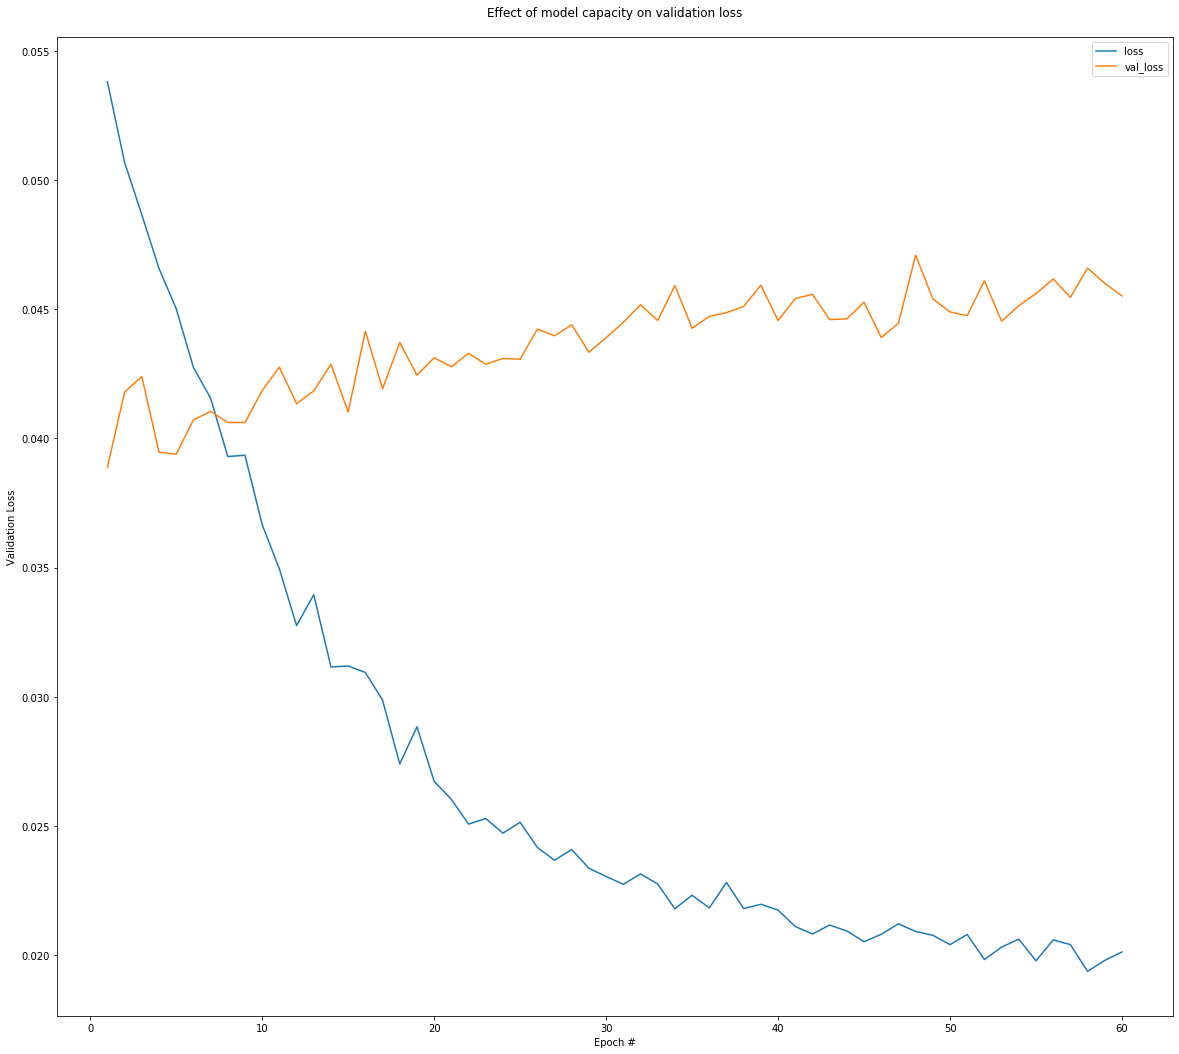

In [19]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = np.arange(60) + 1
plt.figure(figsize=(20,18))
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [9]:
filepath = "D:\桌面\空气质量预测综合\北京多站点空气质量数据集\北京天坛\\12hourweights\DAQFF_model_weights_best.hdf5"
Daqff1.load_weights(filepath)

In [10]:
predict=Daqff1.predict(test_x)
predict=scaler1.inverse_transform(predict)

In [11]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y))).numpy().mean()

58.118129305252346

In [12]:
tf.losses.mae(predict,scaler1.inverse_transform(test_y)).numpy().mean()

51.40890070336031

In [13]:
print(tf.sqrt(tf.losses.mean_squared_error(predict[:,:6],scaler1.inverse_transform(test_y)[:,:6])).numpy().mean())
print(tf.losses.mae(predict[:,:6],scaler1.inverse_transform(test_y)[:,:6]).numpy().mean())
print(tf.sqrt(tf.losses.mean_squared_error(predict[:,6:],scaler1.inverse_transform(test_y)[:,6:])).numpy().mean())
print(tf.losses.mae(predict[:,6:],scaler1.inverse_transform(test_y)[:,6:]).numpy().mean())

44.646854170524946
40.36883479618212
65.92065184899151
62.448966610538506


In [13]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mean_squared_error(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 29.824813994811123
1 : 43.200132686331834
2 : 53.32864733661915
3 : 63.78196497842432
4 : 72.68411352331817
5 : 79.32446968984134
6 : 85.59496774382401


In [14]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mae(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 4.451640317072917
1 : 5.290293727280669
2 : 5.899426013128962
3 : 6.589569184616805
4 : 7.052037706070906
5 : 7.401350546555129
6 : 7.783696323832404


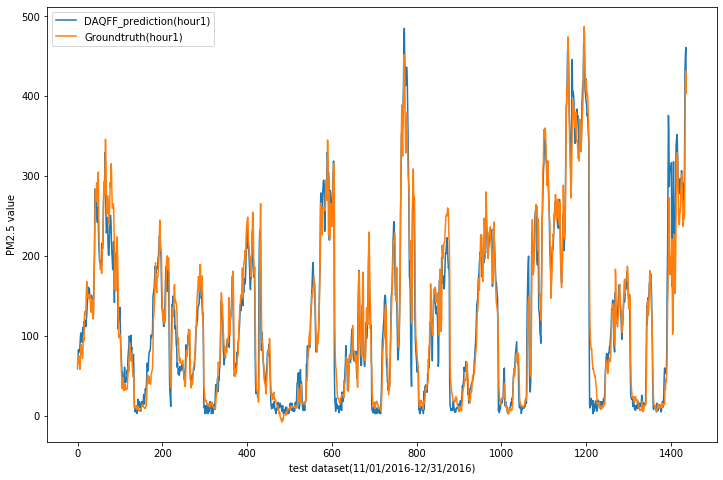

In [20]:
plt.figure(figsize=(12,8))
plt.plot(scaler1.inverse_transform(test_y)[:,0],label='DAQFF_prediction(hour1)')
plt.plot(predict[:,0],label='Groundtruth(hour1)')
plt.xlabel('test dataset(11/01/2016-12/31/2016)')
plt.ylabel('PM2.5 value')
plt.legend()
plt.show()

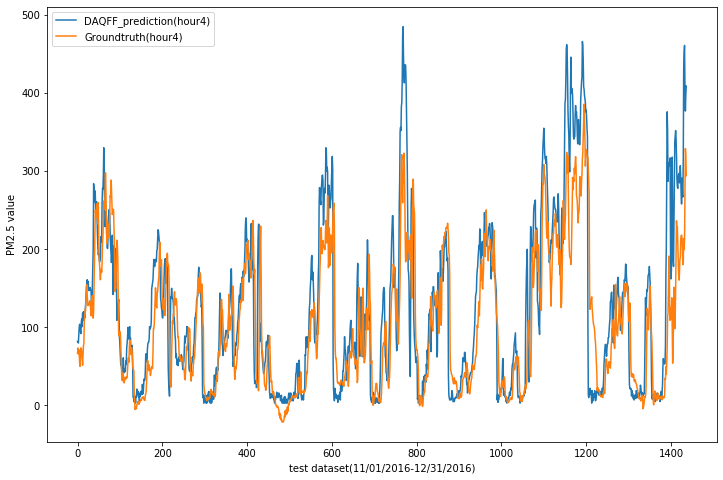

In [21]:
plt.figure(figsize=(12,8))
plt.plot(scaler1.inverse_transform(test_y)[:,3],label='DAQFF_prediction(hour4)')
plt.plot(predict[:,3],label='Groundtruth(hour4)')
plt.xlabel('test dataset(11/01/2016-12/31/2016)')
plt.ylabel('PM2.5 value')
plt.legend()
plt.show()

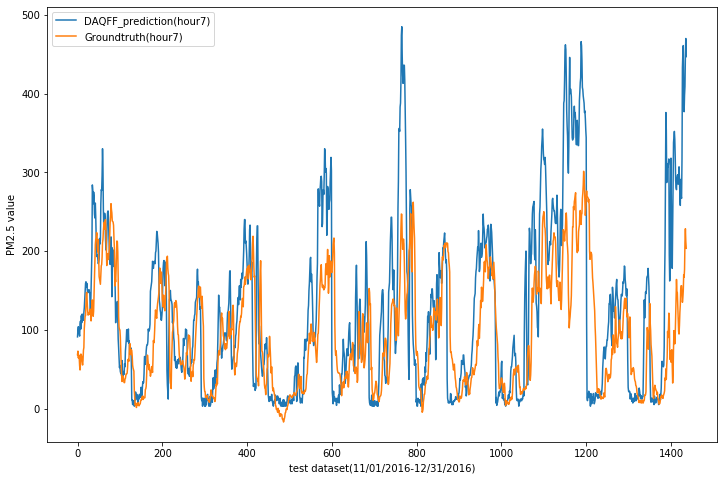

In [22]:
plt.figure(figsize=(12,8))
plt.plot(scaler1.inverse_transform(test_y)[:,6],label='DAQFF_prediction(hour7)')
plt.plot(predict[:,6],label='Groundtruth(hour7)')
plt.xlabel('test dataset(11/01/2016-12/31/2016)')
plt.ylabel('PM2.5 value')
plt.legend()
plt.show()